In [24]:
#IMPORT NECESSARY BUILT IN LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [25]:
#IMPORT ML LIBRARIES - FOR MODULES 4,5,6,7
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete,average
from sklearn.metrics.pairwise import cosine_similarity,nan_euclidean_distances 
from sklearn.cluster import DBSCAN,AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestNeighbors
from mlxtend.frequent_patterns import apriori, association_rules


In [26]:
#IMPORT & INTEGRATE DATA - PROJECT SPECIFIC
#--------------------------------------------
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1

In [27]:
#INTEGRATE DATA 
#------------------------------------------------
df = pd.merge(df_offers, df_transactions)
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], aggfunc='size',fill_value=0)
matrix = matrix.fillna(0).reset_index()
x_cols = matrix.columns[1:]

data = df

In [28]:
#ANALYSE THE DATA DISTRIBUTION AND ATTRIBUTE'S CORRELATION
#----------------------------------------------------------
print('SIZE OF DATA:\n', df.shape)   

SIZE OF DATA:
 (328, 9)


In [29]:
print('ATTRIBUTE LIST:\n', df.columns)

ATTRIBUTE LIST:
 Index(['offer_id', 'campaign', 'varietal', 'min_qty', 'discount', 'origin',
       'past_peak', 'customer_name', 'n'],
      dtype='object')


In [30]:
print('DATA TYPE OF ATTRIBUTES:\n', df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 0 to 327
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   offer_id       328 non-null    int64 
 1   campaign       328 non-null    object
 2   varietal       328 non-null    object
 3   min_qty        328 non-null    int64 
 4   discount       328 non-null    int64 
 5   origin         328 non-null    object
 6   past_peak      328 non-null    bool  
 7   customer_name  328 non-null    object
 8   n              328 non-null    int64 
dtypes: bool(1), int64(4), object(4)
memory usage: 23.4+ KB
DATA TYPE OF ATTRIBUTES:
 None


In [31]:
print('NUMERICAL ATTRIBUTE STATISTIC:\n', df.describe())

NUMERICAL ATTRIBUTE STATISTIC:
          offer_id     min_qty    discount      n
count  328.000000  328.000000  328.000000  328.0
mean    17.009146   57.987805   59.454268    1.0
std      9.692674   49.676136   20.299991    0.0
min      1.000000    6.000000   17.000000    1.0
25%      8.000000    6.000000   45.000000    1.0
50%     18.000000   72.000000   56.000000    1.0
75%     26.000000   72.000000   83.000000    1.0
max     32.000000  144.000000   89.000000    1.0


In [32]:
print('SAMPLE DATA:\n',df.head()) 

SAMPLE DATA:
    offer_id campaign varietal  min_qty  discount  origin  past_peak  \
0         1  January   Malbec       72        56  France      False   
1         1  January   Malbec       72        56  France      False   
2         1  January   Malbec       72        56  France      False   
3         1  January   Malbec       72        56  France      False   
4         1  January   Malbec       72        56  France      False   

  customer_name  n  
0        Thomas  1  
1       Jackson  1  
2      Mitchell  1  
3      Peterson  1  
4          Wood  1  


In [33]:
subsetForClust=matrix.iloc[0:matrix.shape[0], 1:matrix.shape[1]]

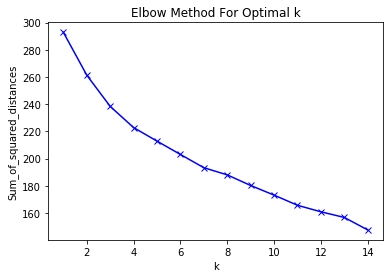

In [11]:
#KMEANS------------------ELBOW METHOD------------------------------------------
#GET OPTIMAL K & SUBSTITUTE IN THE NEXT STEP FOR KMEAN INPUT-------------------
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(subsetForClust)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [34]:
expectedNumber = 4
print('K MEANS WITH NO.OF.CLUSTER :',expectedNumber ,'\n')
kmeans = KMeans(n_clusters=expectedNumber)
km=kmeans.fit(subsetForClust)
y_pred = kmeans.predict(subsetForClust)
print('CLUSTER FORMED WITH LABELS: ',y_pred,'\n')
cluster_labels_ = km.labels_

K MEANS WITH NO.OF.CLUSTER : 4 

CLUSTER FORMED WITH LABELS:  [0 3 2 0 1 1 2 0 3 0 3 2 0 1 3 2 3 2 0 3 0 0 3 3 2 3 3 3 1 2 0 0 3 3 0 0 3
 0 3 0 2 2 0 1 0 3 0 0 3 3 3 1 3 2 1 0 2 0 0 1 1 0 1 0 0 2 2 3 1 3 3 3 3 0
 1 0 2 0 0 2 3 3 3 2 0 0 0 3 3 0 1 0 3 0 3 1 0 1 3 1] 



In [35]:
#INTERPRETATION - REFER TO MY CONTACT SESSION ON THIS SECTION APPLICATION SPECIFIC POST PROCESSING 
#-------------------------------------------------------------------------------------------------

cluster_map = pd.DataFrame()
cluster_map['data_index'] = matrix.index.values
cluster_map['cluster'] = cluster_labels_
    
    
matrix1=matrix.merge(cluster_map, left_on=matrix.index, right_on=cluster_map.index,suffixes=('_left', '_right'))
for customers in matrix1.index:
    for trans in df_transactions.index:
        if df_transactions['customer_name'][trans]==matrix1['customer_name'][customers]:
            #df_transactions['n'][trans]=matrix1['cluster'][customers]
            df_transactions['n'][trans]=matrix1['cluster'][customers]
df_transactions  
df_clustersByOffer = df_transactions.groupby(['offer_id','n']).count()

df_clustersByOfferToMerge=df_clustersByOffer.pivot_table(index=['offer_id'], columns=['n'],values=['customer_name'], aggfunc='sum',fill_value=0)

finalClusterAnalysis=df_offers.merge(df_clustersByOfferToMerge, left_on=df_offers.offer_id, right_on=df_clustersByOfferToMerge.index,suffixes=('_left', '_right'))
    
finalClusterAnalysis.head()

G:\DSE\Anaconda 2018-12 Platform\Anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
G:\DSE\Anaconda 2018-12 Platform\Anaconda\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,key_0,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,"(customer_name, 0)","(customer_name, 1)","(customer_name, 2)","(customer_name, 3)"
0,1,1,January,Malbec,72,56,France,False,0,2,1,7
1,2,2,January,Pinot Noir,72,17,France,False,0,0,6,4
2,3,3,February,Espumante,144,32,Oregon,True,2,1,0,3
3,4,4,February,Champagne,72,48,France,True,0,3,0,9
4,5,5,February,Cabernet Sauvignon,144,44,New Zealand,True,0,0,0,4


In [41]:
#ASSOCIATION ANALYSIS------------------------------------
clusterToStudy = 1 #Refer the latest clustering algorithm used and accordingly input the cluster ID/Label. 
# cluster_labels_In earlier section density cluster has overwritten the clusters formed in previous heirarchical cluster. 
from sklearn.preprocessing import OneHotEncoder
basket = df_transactions[df_transactions['n']==3]
basket2 = basket
basket2.drop('n',inplace=True, axis=1)
basket2.fillna(0)

G:\DSE\Anaconda 2018-12 Platform\Anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,customer_name,offer_id
19,Davis,12
20,Davis,22
21,Davis,25
22,Garcia,14
23,Garcia,15
...,...,...
319,Fisher,11
320,Fisher,22
321,Fisher,28
322,Fisher,30


In [37]:
#ASSOCIATION ANALYSIS -LABEL - DATA APP SPECIFIC IMPLEMENTATION
#---------------------------------------------------------------
def encode_units(x):
    if int(x) <= 0:
        return 0
    if int(x) >= 1:
        return 1


def applyTransformationOn(dataFrame):
    for cols in dataFrame.columns:
        dataFrame[cols] = dataFrame[cols].map(lambda x: encode_units(x))
    return dataFrame

In [38]:
#PREPROCESS TO TRANSFORM INTO TRANSACTION DATA
#----------------------------------------------------------
encodedOfferAttributes = pd.get_dummies(basket2.offer_id, prefix='Offer')
basket2=basket2.merge(encodedOfferAttributes, left_on=basket2.index, right_on=encodedOfferAttributes.index,suffixes=('_left', '_right'))
basket2.drop('offer_id',inplace=True, axis=1)
basket2.drop('key_0',inplace=True, axis=1)
basketAnalyse = basket2.groupby(['customer_name']).sum()
basketAnalyse = applyTransformationOn(basketAnalyse)

In [39]:
basketAnalyse

,Offer_1,Offer_3,Offer_4,Offer_6,Offer_7,Offer_8,Offer_9,Offer_10,Offer_11,Offer_14,...,Offer_20,Offer_21,Offer_22,Offer_23,Offer_27,Offer_28,Offer_29,Offer_30,Offer_31,Offer_32
customer_name,,,,,,,,,,,,,,,,,,,,,
Baker,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
Barnes,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0
Clark,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
Gonzalez,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Kelly,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
Miller,0,0,0,1,0,0,0,1,0,1,...,0,0,1,1,0,0,0,0,1,0
Morales,0,0,0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
Nelson,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Nguyen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [51]:
#APRIORI ALGORITHM IMPLEMENTATION
#--------------------------------------------------
frequent_itemsets = apriori(basketAnalyse, min_support=0.25,max_len=3, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.35)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Offer_6),(Offer_31),0.3125,1.000,0.3125,1.000,1.0,0.0,inf
1,(Offer_10),(Offer_31),0.2500,1.000,0.2500,1.000,1.0,0.0,inf
2,(Offer_22),(Offer_31),0.3750,1.000,0.3750,1.000,1.0,0.0,inf
3,(Offer_31),(Offer_22),1.0000,0.375,0.3750,0.375,1.0,0.0,1.0


offer_6-->offer31      31%       100%


offer_31-->offer_22              37%

In [ ]:
interestingRules= rules[ (rules['lift'] >= 17.0) & (rules['confidence'] >=0.9)]
interestingRules.head()